<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit4/Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
# Just copying from the AK
cs_data = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv')
cs_data.insert(loc=4,column='diff_TminusE',value=cs_data.theo - cs_data.exp)

aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [3]:
# My model
with pm.Model(coords=aa_coords) as cs_custom_h_model:
    μ_mu = pm.StudentT('μ_mu', mu = 0, nu=1, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=1, sigma = 10)
    μ_nu = pm.HalfStudentT('μ_nu', nu=1, sigma = 7)

    μ = pm.StudentT('μ',
                  mu = μ_mu,
                    nu = μ_nu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ',
                        nu = 1,
                        sigma = 10,
                      dims = "aa")

    nu = pm.HalfStudentT('nu',
                         nu = 1,
                         sigma = 7,
                         dims = "aa")

    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  nu = nu[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    idata_cs_custom_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ_nu, μ, σ, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [4]:
# AK model
with pm.Model(coords=aa_coords) as cs_h_model:
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


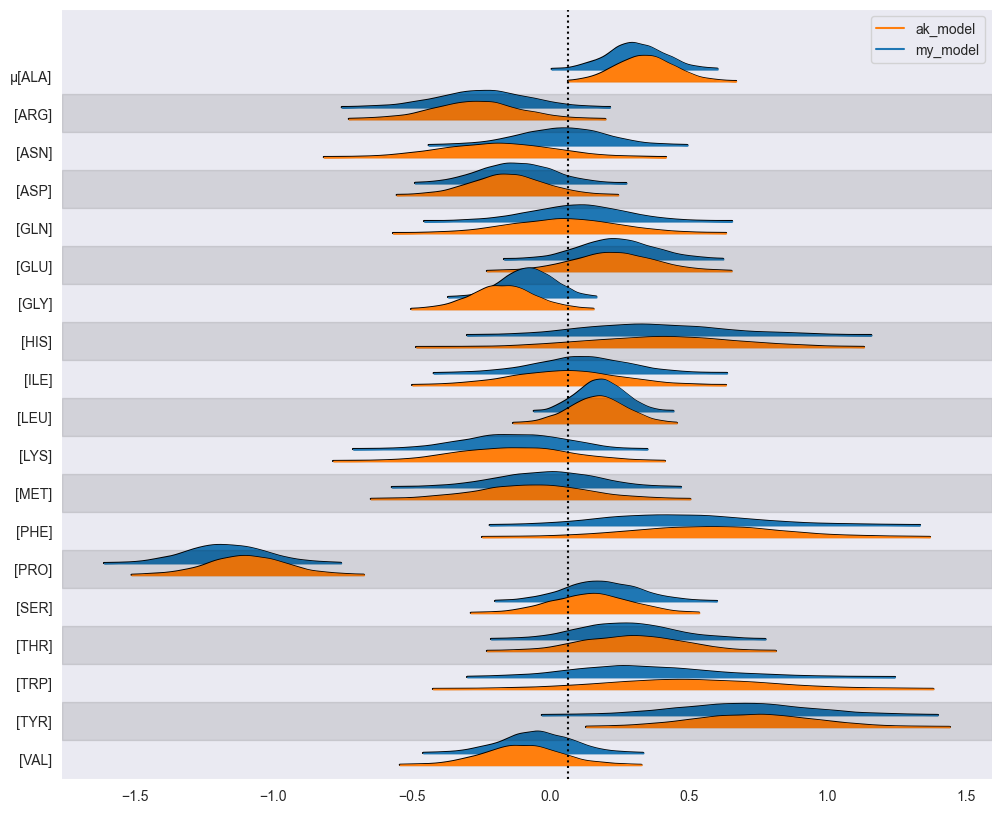

In [5]:
# Comparison (mostly copied from AK)
axes = az.plot_forest([idata_cs_custom_h, idata_cs_h], kind="ridgeplot",
                      model_names=['my_model', 'ak_model'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");


**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Sampling: [y]


Output()

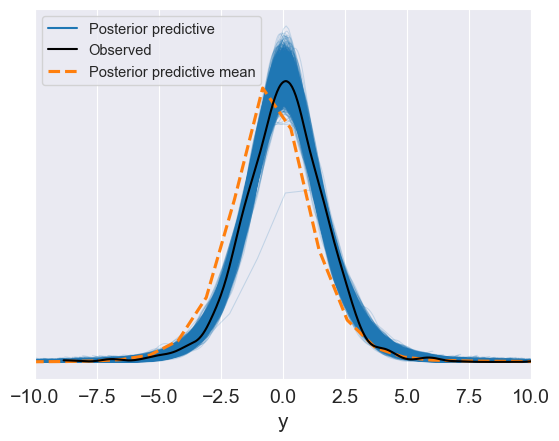

In [6]:
# My Model
pm.sample_posterior_predictive(idata_cs_custom_h, model=cs_custom_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_custom_h).set_xbound(lower=-10, upper=10)

Sampling: [y]


Output()

/Users/malcolmroalson/Documents/DataSpell/data-science-fundamentals/venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/malcolmroalson/Documents/DataSpell/data-science-fundamentals/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


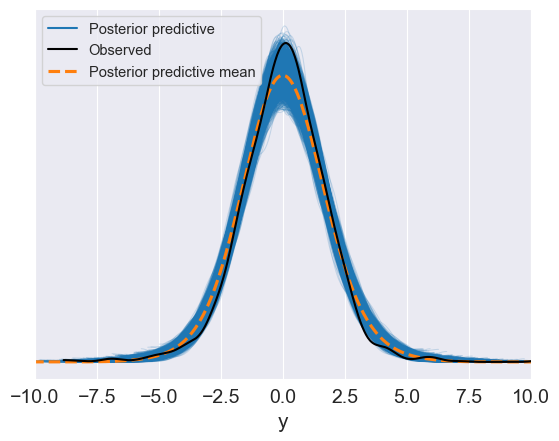

In [7]:
# AK Model
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_h).set_xbound(lower=-10, upper=10)

**Answer**

The StudentT generally seems to fit the data better, though both are pretty good. The normal's peak is a little too low and doesn't quite capture the shape of the curve as well.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [8]:
# Grab the data
sccr_data = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv', dtype={'position':'category'})
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [9]:
# Non-hierarchical model
with pm.Model(coords = sccr_coords) as sccr_model:
    # use the means of the previous hyperpriors for the values
    μ_p = pm.Beta('μ_p', mu = 0.09, nu = 55, dims="pos")
    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values,
                    p = θ,
                    observed = sccr_data.goals.values)

    idata_sccr = pm.sample(target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_p, ν_p, θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 230 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

In [15]:
# From AK
az.plot_trace(idata_sccr)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x11f058dc0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x16dfdd630> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [13]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.002 1.001 1.002 ... 1.003 1.001 1.002
    μ_p      (pos) float64 32B 1.001 1.0 1.069 1.001
    ν_p      (pos) float64 32B 1.021 1.002 1.336 1.006

**Comparison to Hierarchical**

We've got two fewer graphs, as we no longer have the hyperpriors. The amplitudes are a little more unsteady, particularly in the θ plot and ν_p.

The GK's μ_p $\hat{R}$ is a little better, but still outside of our desired range. However, the GK's ν_p $\hat{R}$ is significantly worse than the hierarchical model. Overall they are slightly better, but very similar to the hierarchical. They are probably better because previously the GK was influencing the other positions, and it cannot understand the GK.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

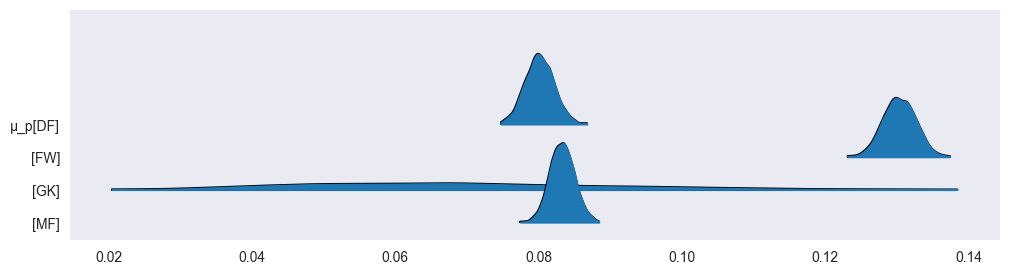

In [14]:
# From the answer key, plutting mu_p
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**Comparison to Hierarchical**

The means of the posteriors are basically the same to the hierarchical model. It also still cannot model the GK - however GK is a little different as previously the other posteriors were drawing it inwards. The main difference is that the non-hierarchical model's posteriors are narrower, with a smaller standard deviation. This is due to the lack of the hyperpriors, as previously each position could influence one another - meaning the GK was drawing the variances significantly wider.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.


In [61]:
# Copy loading, but take out GK
sccr_data_no_GK = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv', dtype={'position':'category'})
sccr_data_no_GK = sccr_data_no_GK[sccr_data_no_GK.position != 'GK'] # we <3 StackOverflow
sccr_data_no_GK.position = sccr_data_no_GK.position.cat.remove_unused_categories()

pos_idx_no_GK = sccr_data_no_GK.position.cat.codes.values
pos_codes_no_GK = sccr_data_no_GK.position.cat.categories
sccr_coords_no_GK = {"pos": pos_codes_no_GK}

In [62]:
with pm.Model(coords = sccr_coords_no_GK) as sccr_model_no_GK:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_no_GK], nu = ν_p[pos_idx_no_GK])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_no_GK.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_no_GK.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_no_GK = pm.sample(target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, ν, μ_p, ν_p, θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

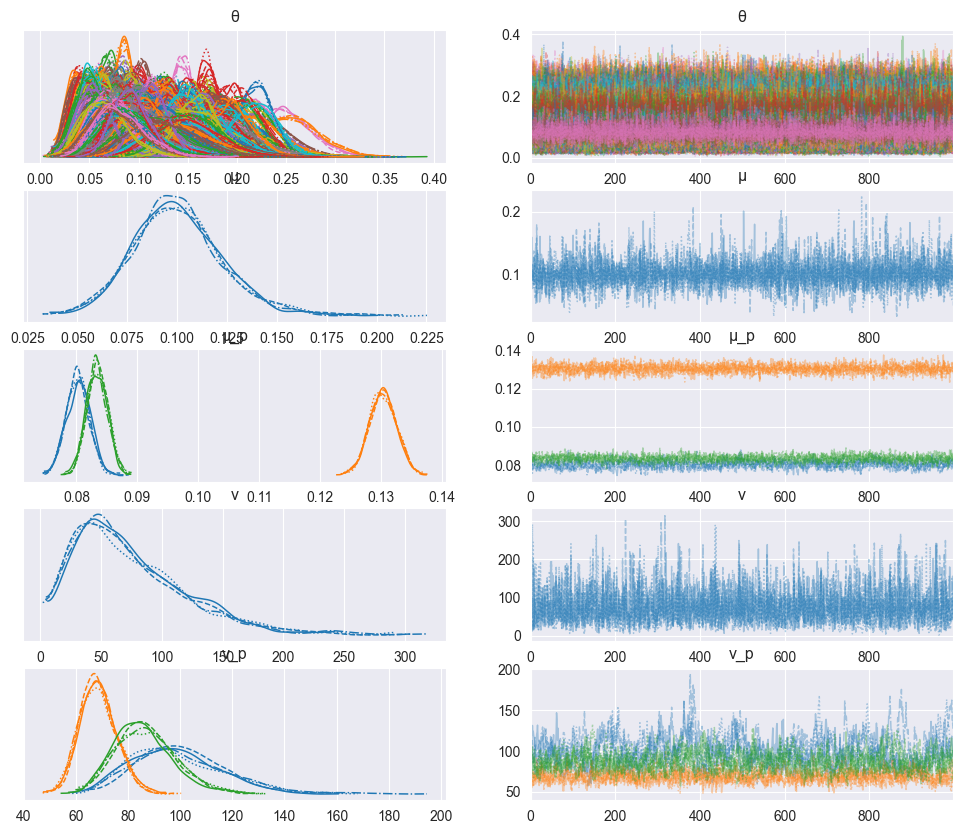

In [63]:
az.plot_trace(idata_sccr_no_GK)

In [64]:
az.rhat(idata_sccr_no_GK)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.002 1.0 1.001 1.0 ... 1.003 1.001 1.003
    μ        float64 8B 1.003
    μ_p      (pos) float64 24B 1.003 1.0 1.001
    ν        float64 8B 1.0
    ν_p      (pos) float64 24B 1.007 1.004 1.008

**Comparison**

The model can definitely process the model without the GKs better. The trace plots are much smoother (particularly v_p and mu_p, as they are pretty much all horizontal) and the $\hat{R}$ values are much closer to the desired range. They're still (mostly) outside 1.001, but they're at least on the right order of magnitude. By dropping GKs, we gain a much better model for the remaining positions, as the model can now focus on them and not be influenced by the GKs. However, we lose the ability to model the GKs, which is a pretty big loss if we're interested in them.